In [20]:
import os
import time

import numpy as np
from sklearn.metrics import average_precision_score
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.nn.utils.clip_grad import clip_grad_norm_

import torchvision.ops
import torchvision.transforms as transforms
from torchvision.datasets import VOCDetection
from torchvision.transforms.functional import to_pil_image

In [2]:
NUMBER_OF_CLASSES = 20  # Assuming 20 classes from VOC dataset
GRID_SIZE = 7  # Grid size (e.g., 7 x 7)
NUMBER_OF_BBOXES = 3  # Number of bounding boxes per grid cell (e.g., 3)
IMAGE_SIZE = 448

BATCH_SIZE = 64

# Define a mapping for VOC labels to integers
VOC_LABELS = {
    'aeroplane': 0, 'bicycle': 1, 'bird': 2, 'boat': 3,
    'bottle': 4, 'bus': 5, 'car': 6, 'cat': 7,
    'chair': 8, 'cow': 9, 'diningtable': 10, 'dog': 11,
    'horse': 12, 'motorbike': 13, 'person': 14, 'pottedplant': 15,
    'sheep': 16, 'sofa': 17, 'train': 18, 'tvmonitor': 19
}

In [3]:
def non_max_suppression(prediction, conf_thresh=0.5, iou_thresh=0.4):
    """
    Applies Non-Maximum Suppression to filter out overlapping bounding boxes.

    Args:
        prediction (Tensor): The prediction tensor with shape (batch_size, N_BBOXES * (5 + num_classes), grid_size, grid_size).
        conf_thresh (float): The confidence threshold to filter predictions.
        iou_thresh (float): The IoU threshold to apply for NMS.

    Returns:
        list: The filtered bounding boxes after applying NMS.
    """
    batch_size = prediction.size(0)
    num_anchors = NUMBER_OF_BBOXES
    num_classes = NUMBER_OF_CLASSES

    # Convert predictions to bounding box parameters
    prediction = prediction.view(
        batch_size, num_anchors, 5 + num_classes, GRID_SIZE, GRID_SIZE).permute(0, 1, 3, 4, 2).contiguous()

    # Get the x, y coordinates and the width, height of the boxes
    box_corner = prediction[..., :4]
    x = box_corner[..., 0]
    y = box_corner[..., 1]
    w = box_corner[..., 2]
    h = box_corner[..., 3]

    # Convert from (x, y, w, h) to (x1, y1, x2, y2)
    x1 = x - w / 2
    y1 = y - h / 2
    x2 = x + w / 2
    y2 = y + h / 2

    # Get objectness score and class scores
    objectness = prediction[..., 4]
    class_scores = prediction[..., 5:]

    # Calculate overall scores (objectness score * highest class score)
    overall_scores, class_indices = torch.max(class_scores, -1)
    overall_scores *= objectness

    # Filter out boxes with a low objectness score
    mask = overall_scores > conf_thresh
    filtered_boxes = []

    for i in range(batch_size):
        # Apply the mask to the boxes and scores
        boxes = torch.cat((x1[i][mask[i]], y1[i][mask[i]],
                          x2[i][mask[i]], y2[i][mask[i]]), 1)
        scores = overall_scores[i][mask[i]]
        class_inds = class_indices[i][mask[i]]

        # Apply NMS to the boxes
        keep = torchvision.ops.nms(boxes, scores, iou_thresh)

        # Keep only the boxes specified by NMS
        final_boxes = boxes[keep]
        final_scores = scores[keep]
        final_class_inds = class_inds[keep]

        # Append to the list of filtered boxes
        filtered_boxes.append((final_boxes, final_scores, final_class_inds))

    return filtered_boxes


In [4]:
class TinyYOLO(nn.Module):
    """
    Tiny YOLO model for object detection.

    Args:
        num_classes (int): Number of classes in the dataset.

    Attributes:
        num_classes (int): Number of classes in the dataset.
        features (nn.Sequential): The feature extractor.
        output (nn.Conv2d): The output layer.
    """

    def __init__(self, num_classes=NUMBER_OF_CLASSES):
        super(TinyYOLO, self).__init__()
        self.num_classes = num_classes

        # Define the layers
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(512, 1024, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.1),
        )

        # Output layer
        self.output = nn.Conv2d(1024, (5 + num_classes)
                                * NUMBER_OF_BBOXES, kernel_size=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass of the network.

        Args:
            x (Tensor): The input tensor.

        Returns:
            Tensor: The output tensor.
        """
        x = self.features(x)
        x = self.output(x)
        return x

    def detect(self, images: torch.Tensor, conf_thresh: float = 0.5, iou_thresh: float = 0.4) -> list:
        """
        Detect objects in the input images.

        Args:
            images (Tensor): The input images
            conf_thresh (float): Confidence threshold
            iou_thresh (float): IOU threshold for NMS

        Returns:
            list: Processed predictions after NMS
        """
        with torch.no_grad():
            predictions = self(images)
            # Apply NMS to each image's predictions
            nms_predictions = [non_max_suppression(
                pred, conf_thresh, iou_thresh) for pred in predictions]
            return nms_predictions

In [5]:
class YOLOLoss(nn.Module):
    """
    Custom loss function for YOLO.
    """

    def __init__(self, S, B, C, lambda_coord, lambda_noobj):
        super(YOLOLoss, self).__init__()
        self.S = S
        self.B = B
        self.C = C
        self.lambda_coord = lambda_coord  # Weight for box coordinate prediction loss
        self.lambda_noobj = lambda_noobj  # Weight for no-object loss

    def forward(self, predictions, target):
        # Reshape predictions and target to the correct format
        pred = predictions.view(-1, self.B, 5 + self.C,
                                self.S, self.S).permute(0, 3, 4, 1, 2)
        targ = target.view(-1, self.B, 5 + self.C, self.S,
                           self.S).permute(0, 3, 4, 1, 2)

        # Extract individual components from predictions and target
        pred_boxes = pred[..., :5]
        pred_classes = pred[..., 5:]

        targ_boxes = targ[..., :5]
        targ_classes = targ[..., 5:]

        # Compute losses
        # Bounding box loss for x, y, w, h
        box_loss = F.mse_loss(
            pred_boxes[..., :4], targ_boxes[..., :4], reduction='sum')

        # Objectness loss
        obj_loss = F.mse_loss(
            pred_boxes[..., 4], targ_boxes[..., 4], reduction='sum')

        # Class loss
        class_loss = F.binary_cross_entropy_with_logits(
            pred_classes, targ_classes, reduction='sum')

        # Combine losses
        loss = self.lambda_coord * box_loss + self.lambda_noobj * obj_loss + class_loss
        return loss

In [6]:
def calculate_ap_per_class(tp, conf, pred_cls, target_cls):
    """
    Calculate the average precision, given true positive, confidence, 
    and predicted and target classes.
    """
    # Sort by confidence
    i = np.argsort(-conf)
    tp, conf, pred_cls = tp[i], conf[i], pred_cls[i]

    # Find unique classes
    unique_classes = np.unique(target_cls)

    # Create an AP dictionary
    ap_dict = dict()
    for c in unique_classes:
        # All predictions and targets for this class
        pred_for_class = pred_cls == c
        target_for_class = target_cls == c

        # Compute average precision
        if np.sum(target_for_class) == 0:
            ap_dict[c] = 0.0
            continue

        ap = average_precision_score(target_for_class, conf[pred_for_class])
        ap_dict[c] = ap

    return ap_dict


def convert_predictions_to_boxes(predictions, conf_thresh):
    """
    Convert predictions of the model to bounding boxes.
    """
    batch_size = predictions.size(0)
    num_anchors = NUMBER_OF_BBOXES
    num_classes = NUMBER_OF_CLASSES
    grid_size = GRID_SIZE

    # Reshape predictions to (batch_size, num_anchors, (5 + num_classes), grid_size, grid_size)
    predictions = predictions.view(batch_size, num_anchors, 5 + num_classes,
                                   grid_size, grid_size).permute(0, 1, 3, 4, 2).contiguous()

    # Convert to bounding box attributes
    x = torch.sigmoid(predictions[..., 0])  # Center x
    y = torch.sigmoid(predictions[..., 1])  # Center y
    w = predictions[..., 2]  # Width
    h = predictions[..., 3]  # Height
    conf = torch.sigmoid(predictions[..., 4])  # Conf
    class_probs = torch.sigmoid(predictions[..., 5:])  # Class probabilities

    # Filter out boxes with low object confidence
    conf_mask = conf > conf_thresh
    detections = []

    for i in range(batch_size):
        boxes = torch.zeros(
            (conf_mask[i].sum(), 5 + num_classes), device=predictions.device)
        if boxes.numel() == 0:  # No detections for this image
            detections.append(None)
            continue

        # Compute box corner positions
        boxes[:, :4] = torch.stack((x[i][conf_mask[i]] - w[i][conf_mask[i]] / 2,
                                    y[i][conf_mask[i]] -
                                    h[i][conf_mask[i]] / 2,
                                    x[i][conf_mask[i]] +
                                    w[i][conf_mask[i]] / 2,
                                    y[i][conf_mask[i]] + h[i][conf_mask[i]] / 2), 1)
        boxes[:, 4] = conf[i][conf_mask[i]]
        boxes[:, 5:] = class_probs[i][conf_mask[i]]

        detections.append(boxes)

    return detections


def calculate_iou(boxes1, boxes2):
    """
    Calculate the intersection over union (IoU) between two sets of boxes.

    This is a measurement of the overlap between two sets of boxes.
    """
    # Calculate intersection areas
    inter_x1 = torch.max(boxes1[:, 0], boxes2[:, 0])
    inter_y1 = torch.max(boxes1[:, 1], boxes2[:, 1])
    inter_x2 = torch.min(boxes1[:, 2], boxes2[:, 2])
    inter_y2 = torch.min(boxes1[:, 3], boxes2[:, 3])

    inter_area = torch.clamp(inter_x2 - inter_x1 + 1, min=0) * \
        torch.clamp(inter_y2 - inter_y1 + 1, min=0)

    # Calculate union areas
    boxes1_area = (boxes1[:, 2] - boxes1[:, 0] + 1) * \
        (boxes1[:, 3] - boxes1[:, 1] + 1)
    boxes2_area = (boxes2[:, 2] - boxes2[:, 0] + 1) * \
        (boxes2[:, 3] - boxes2[:, 1] + 1)

    union_area = boxes1_area + boxes2_area - inter_area

    # Compute IoU
    iou = inter_area / union_area

    return iou


def match_predictions(iou, iou_thresh):
    """
    Match predictions to ground truth boxes.
    """
    matches = []
    for i in range(iou.size(0)):
        if iou[i] > iou_thresh:
            matches.append(i)
    return matches


def update_metrics(matches, scores, pred_labels, gt_labels):
    """
    Update true positives, false positives, confidences, and class predictions.
    """

    tp = np.zeros(len(scores))
    fp = np.zeros(len(scores))
    for i, match in enumerate(matches):
        if pred_labels[i] == gt_labels[match]:
            tp[i] = 1
        else:
            fp[i] = 1
    return tp, fp, scores, pred_labels

In [7]:
def train_model(model, train_loader, validation_loader, num_epochs=10):
    """
    Main training loop for the model.
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Training on device '{device}'.")

    # Define the loss function with the appropriate parameters
    loss_function = YOLOLoss(
        S=GRID_SIZE, B=NUMBER_OF_BBOXES, C=NUMBER_OF_CLASSES, lambda_coord=1.0, lambda_noobj=0.1)
    # Define the optimizer
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    # Define the learning rate scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, 'min', patience=3, factor=0.1)

    # Transfer the model to the GPU
    model.to(device)

    # Initialize lists to track losses
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        total_loss = 0

        # Use tqdm for progress bar
        progress_bar = tqdm(
            train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)

        for images, targets in progress_bar:
            # Transfer images and targets to the GPU
            images = images.to(device)
            targets = targets.to(device)

            # Zero the gradients on each iteration
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)

            # Calculate the loss
            loss = loss_function(outputs, targets)

            # Backward pass
            loss.backward()

            # Clip gradients to avoid exploding gradients
            clip_grad_norm_(model.parameters(), max_norm=1.0)

            # Update weights
            optimizer.step()

            # Accumulate the loss
            total_loss += loss.item()

            # Update the progress bar
            progress_bar.set_postfix(train_loss=total_loss / len(train_loader))

        # Calculate the average loss for the epoch
        avg_train_loss = total_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validate the model
        avg_val_loss = validate(
            model, validation_loader, loss_function, device)
        val_losses.append(avg_val_loss)

        # Update the learning rate scheduler
        scheduler.step(avg_val_loss)

        # Print the loss for the epoch
        print(
            f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")

        # Save the model if it has the best validation loss so far
        if epoch == 0 or avg_val_loss < min(val_losses[:-1]):
            torch.save(model.state_dict(), 'model_best.pth')

    # Plot the training and validation losses
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    return model


def validate(model, validation_loader, loss_function, device):
    """
    Validation step during training.
    """
    model.eval()  # Set the model to evaluation mode
    total_loss = 0

    # Initialize tqdm progress bar
    progress_bar = tqdm(validation_loader, desc="Validating", leave=False)

    with torch.no_grad():  # Turn off gradients for validation, saves memory and computations
        for images, targets in progress_bar:
            images = images.to(device)
            targets = targets.to(device)
            outputs = model(images)
            loss = loss_function(outputs, targets)
            total_loss += loss.item()

            # Update the progress bar
            progress_bar.set_postfix(
                val_loss=total_loss / len(validation_loader))

    return total_loss / len(validation_loader)


def evaluate_map(model, test_loader, iou_thresh=0.5, conf_thresh=0.5):
    """
    Evaluate the model on the test set and calculate the mAP.
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device).eval()

    # Lists to store true positives, confidences, and class predictions
    all_tp = []
    all_conf = []
    all_pred_cls = []
    all_target_cls = []

    with torch.no_grad():
        for images, targets in test_loader:
            images = images.to(device)

            # Get model predictions
            predictions = model(images)

            # Convert predictions to bounding box format and apply NMS
            batch_detections = convert_predictions_to_boxes(
                predictions, conf_thresh=conf_thresh)

            # Iterate over each image in the batch
            for idx, detections in enumerate(batch_detections):
                # Get ground truth boxes and labels for the current image
                gt_boxes = targets['boxes'][idx].cpu().numpy()
                gt_labels = targets['labels'][idx].cpu().numpy()

                # If no boxes are detected, skip the current image
                if detections is None:
                    continue

                # Split detections into boxes, scores, and class labels
                pred_boxes = detections[:, :4]
                scores = detections[:, 4]
                pred_labels = detections[:, 5]

                # Convert to torch Tensors for IoU calculation
                pred_boxes = torch.from_numpy(pred_boxes)
                gt_boxes = torch.from_numpy(gt_boxes)

                # Calculate IoU between each predicted box and ground truth box
                iou = calculate_iou(pred_boxes, gt_boxes)

                # Determine which predicted boxes match with which ground truth boxes
                matches = match_predictions(iou, iou_thresh)

                # Update true positives, false positives, confidences, and class predictions
                tp, fp, conf, pred_cls = update_metrics(
                    matches, scores, pred_labels, gt_labels)

                all_tp.append(tp)
                all_conf.append(conf)
                all_pred_cls.append(pred_cls)
                # Note: extend since gt_labels is not batched
                all_target_cls.extend(gt_labels)

    # Concatenate all results
    all_tp = np.concatenate(all_tp)
    all_conf = np.concatenate(all_conf)
    all_pred_cls = np.concatenate(all_pred_cls)
    all_target_cls = np.concatenate(all_target_cls)

    # Calculate AP per class
    ap_per_class = calculate_ap_per_class(
        all_tp, all_conf, all_pred_cls, all_target_cls)

    # Calculate the mean AP across all classes
    mean_ap = np.mean(list(ap_per_class.values()))

    # Print the results
    print(f"Mean Average Precision: {mean_ap:.4f}")
    for cls, ap in ap_per_class.items():
        print(f"AP for class {cls}: {ap:.4f}")

    return mean_ap

In [8]:
def adjust_bounding_box(target: dict):
    """
    Adjusts the bounding box coordinates from the original image size to the resized image size.

    Args:
        target: dict, containing the annotations including the bounding box coordinates and original image size

    Returns:
        x_min_array: list, containing the adjusted x_min coordinates
        y_min_array: list, containing the adjusted y_min coordinates
        x_max_array: list, containing the adjusted x_max coordinates
        y_max_array: list, containing the adjusted y_max coordinates
        names: list, containing the object names
    """
    # Extract original dimensions
    orig_width = int(target['annotation']['size']['width'])
    orig_height = int(target['annotation']['size']['height'])
    # Extract resized dimensions
    resize_width, resize_height = IMAGE_SIZE, IMAGE_SIZE

    # Calculate scale factors
    x_scale = resize_width / orig_width
    y_scale = resize_height / orig_height

    x_min_array, y_min_array, x_max_array, y_max_array = [], [], [], []
    names = []
    # Iterate over each bounding box
    for obj in target['annotation']['object']:
        bbox = obj['bndbox']
        xmin = int(bbox['xmin'])
        ymin = int(bbox['ymin'])
        xmax = int(bbox['xmax'])
        ymax = int(bbox['ymax'])

        # Adjust bounding box coordinates
        adjusted_xmin = int(xmin * x_scale)
        adjusted_ymin = int(ymin * y_scale)
        adjusted_xmax = int(xmax * x_scale)
        adjusted_ymax = int(ymax * y_scale)

        x_min_array.append(adjusted_xmin)
        y_min_array.append(adjusted_ymin)
        x_max_array.append(adjusted_xmax)
        y_max_array.append(adjusted_ymax)
        names.append(obj['name'])

    return x_min_array, y_min_array, x_max_array, y_max_array, names

In [9]:
def collate_fn(batch):
    """
    Custom collate function for the data loader that handles multiple objects in the same grid cell
    without overwriting bounding boxes.
    """
    images = []
    targets = []

    grid_size = GRID_SIZE
    num_boxes = NUMBER_OF_BBOXES
    num_classes = NUMBER_OF_CLASSES
    image_size = IMAGE_SIZE  # Assuming a square image

    for img, target in batch:
        images.append(img)
        target_tensor = torch.zeros(
            [num_boxes * (5 + num_classes), grid_size, grid_size])

        x_min_array, y_min_array, x_max_array, y_max_array, names = adjust_bounding_box(
            target)

        # Track which boxes have been filled in each cell
        filled_boxes = torch.zeros(
            (grid_size, grid_size, num_boxes), dtype=torch.int64)

        for idx in range(len(x_min_array)):
            xmin = float(x_min_array[idx])
            ymin = float(y_min_array[idx])
            xmax = float(x_max_array[idx])
            ymax = float(y_max_array[idx])

            # Normalize coordinates to [0, 1]
            x_center = ((xmin + xmax) / 2) / image_size
            y_center = ((ymin + ymax) / 2) / image_size
            width = (xmax - xmin) / image_size
            height = (ymax - ymin) / image_size

            # Determine grid cell indices
            grid_x = int(x_center * grid_size)
            grid_y = int(y_center * grid_size)

            # Class label
            label_index = VOC_LABELS[names[idx]]

            # Box coordinates relative to the grid cell
            box_coordinates = torch.tensor(
                [x_center * grid_size - grid_x, y_center * grid_size - grid_y, width, height])

            # Assign to the first available bounding box in this cell
            for b in range(num_boxes):
                if filled_boxes[grid_y, grid_x, b] == 0:
                    box_index = b * (5 + num_classes)
                    target_tensor[box_index:box_index + 4,
                                  grid_y, grid_x] = box_coordinates
                    target_tensor[box_index + 4, grid_y,
                                  grid_x] = 1  # Objectness score
                    target_tensor[box_index + 5 + label_index,
                                  grid_y, grid_x] = 1  # Class label
                    # Mark this bounding box as filled
                    filled_boxes[grid_y, grid_x, b] += 1
                    break

        targets.append(target_tensor)

    images = torch.stack(images)
    targets = torch.stack(targets)

    return images, targets

In [10]:
def get_datasets():
    """
    Download and load the VOC dataset.
    """
    transform = transforms.Compose([
        # Resize to match YOLO input
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[
                             0.229, 0.224, 0.225])
    ])

    # Download and load the training and validation sets
    train_dataset = VOCDetection(
        root='./data', year='2012', image_set='train', download=True, transform=transform)
    val_dataset = VOCDetection(root='./data', year='2012',
                               image_set='trainval', download=True, transform=transform)
    test_dataset = VOCDetection(root='./data', year='2012',
                                image_set='val', download=True, transform=transform)

    return train_dataset, val_dataset, test_dataset


def get_data_loaders(train_dataset, val_dataset, test_dataset):
    """
    Create data loaders for the training, validation, and test sets.
    """
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE,
                              shuffle=True, num_workers=4, collate_fn=collate_fn)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE,
                            shuffle=False, num_workers=4, collate_fn=collate_fn)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE,
                             shuffle=False, num_workers=4, collate_fn=collate_fn)

    return train_loader, val_loader, test_loader


In [11]:
def visualize_dataset_sample(dataset, index):
    """
    Visualizes an image and its annotated bounding boxes from the dataset.

    Args:
    - dataset: the VOC dataset object
    - index: the index of the sample to visualize
    """
    # Retrieve the image and target from the dataset
    img, target = dataset[index]
    # Denormalize colors
    img = img * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    img = img + torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)

    img = to_pil_image(img)  # Convert tensor image to PIL
    # Create a figure and axis for plotting
    _, ax = plt.subplots(1)
    ax.imshow(img)

    x_min_array, y_min_array, x_max_array, y_max_array, names = adjust_bounding_box(
        target)

    # Draw the bounding boxes on the image
    for i in range(len(x_min_array)):
        xmin = int(x_min_array[i])
        ymin = int(y_min_array[i])
        xmax = int(x_max_array[i])
        ymax = int(y_max_array[i])

        # Create a Rectangle patch
        rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                 linewidth=1, edgecolor='r', facecolor='none')

        # Add the patch to the Axes
        ax.add_patch(rect)

        # Add the label
        plt.text(xmin, ymin, names[i], color='white', fontsize=8, bbox=dict(
            facecolor='red', edgecolor='none', pad=1))

    plt.show()

In [12]:
def visualize_collated_sample(image, target_tensor, S=GRID_SIZE, B=NUMBER_OF_BBOXES, C=NUMBER_OF_CLASSES, image_size=IMAGE_SIZE):
    """
    Visualizes an image and its bounding boxes after being processed by the collate_fn.

    Args:
    - image: the image tensor
    - target_tensor: the target tensor in the YOLO format from the collate_fn
    - S: grid size
    - B: number of bounding boxes per grid cell
    - C: number of classes
    - image_size: the size of the image (assuming square image)
    """
    # make a copy of the image tensor
    image = image.clone()

    # Denormalize
    image = image * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    image = image + torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)

    # Convert the image tensor to a PIL image for visualizatiaoen
    img = to_pil_image(image)

    # Create a figure and axis for plotting
    _, ax = plt.subplots(1)
    ax.imshow(img)

    # Reshape the target tensor to the expected format
    target_tensor = target_tensor.view(
        B, 5 + C, S, S).permute(1, 2, 3, 0).contiguous()

    # Count the number of ones in the objectness score
    num_ones = torch.sum(target_tensor[4, :, :, :])
    print(f'Number of ones in objectness score: {num_ones}')

    # Draw the bounding boxes on the image
    for b in range(B):
        for y in range(S):
            for x in range(S):
                box_data = target_tensor[:5, y, x, b]
                cls_data = target_tensor[5:, y, x, b]
                objectness = box_data[4]
                if objectness > 0.5:  # Threshold for visualization
                    # Box coordinates are relative to the grid cell, rescale to image
                    x_center = (box_data[0] + x) / S * image_size
                    y_center = (box_data[1] + y) / S * image_size
                    width = box_data[2] * image_size
                    height = box_data[3] * image_size

                    # Get the class name:
                    class_label = torch.argmax(cls_data)
                    class_name = list(VOC_LABELS.keys())[list(
                        VOC_LABELS.values()).index(int(class_label.item()))]

                    # Convert to xmin, ymin, xmax, ymax
                    xmin = x_center - width / 2
                    ymin = y_center - height / 2
                    xmax = x_center + width / 2
                    ymax = y_center + height / 2

                    # Create a Rectangle patch
                    rect = patches.Rectangle(
                        (xmin, ymin),
                        xmax - xmin,
                        ymax - ymin,
                        linewidth=1,
                        edgecolor='r',
                        facecolor='none'
                    )

                    # Add the patch to the Axes
                    ax.add_patch(rect)

                    class_label = torch.argmax(cls_data)
                    plt.text(
                        xmin,
                        ymin,
                        class_name,
                        color='white',
                        fontsize=8,
                        bbox=dict(facecolor='red', edgecolor='none', pad=1)
                    )

    plt.show()

In [13]:
def get_model(weights=None, train_loader=None, val_loader=None):
    """
    Load model weights from disk if they exist, otherwise train the model.

    Args:
        weights (str): Path to the model weights.
        train_loader (DataLoader): The training data loader.
        val_loader (DataLoader): The validation data loader.

    Returns:
        TinyYOLO: The model.
    """
    model = TinyYOLO(num_classes=NUMBER_OF_CLASSES)

    if weights is not None and os.path.exists(weights):
        print(f'Loading weights from {weights}')
        model.load_state_dict(torch.load(weights))
    else:
        model = train_model(model, train_loader, val_loader, num_epochs=40)
        # Save model with the timestamp
        model_name = f'model_{int(time.time())}.pth'
        torch.save(model.state_dict(), model_name)
        print(f'Saved model as {model_name}')

    return model

In [14]:
# Download, load and prepare the dataset
train_dataset, val_dataset, test_dataset = get_datasets()

Using downloaded and verified file: ./data/VOCtrainval_11-May-2012.tar
Extracting ./data/VOCtrainval_11-May-2012.tar to ./data
Using downloaded and verified file: ./data/VOCtrainval_11-May-2012.tar
Extracting ./data/VOCtrainval_11-May-2012.tar to ./data
Using downloaded and verified file: ./data/VOCtrainval_11-May-2012.tar
Extracting ./data/VOCtrainval_11-May-2012.tar to ./data


In [15]:
train_loader, val_loader, test_loader = get_data_loaders(
    train_dataset, val_dataset, test_dataset)

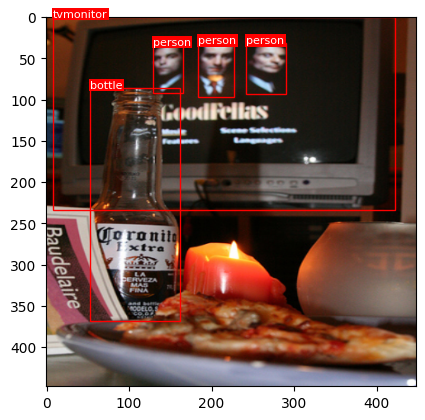

In [16]:
# Visualize a sample from the dataset
index = 9
visualize_dataset_sample(val_dataset, index)

In [17]:
# Visualize a sample from the collated dataset
images, targets = next(iter(val_loader))

Number of ones in objectness score: 5.0


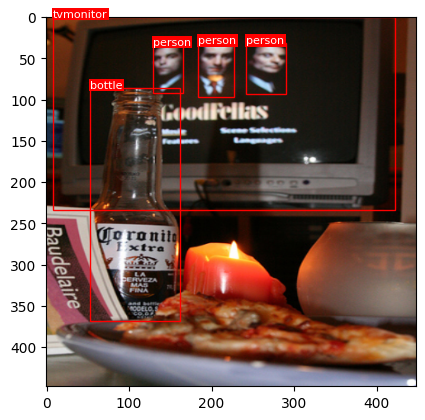

In [18]:
visualize_collated_sample(
    images[index],
    targets[index],
    S=GRID_SIZE,
    B=NUMBER_OF_BBOXES,
    C=NUMBER_OF_CLASSES,
    image_size=IMAGE_SIZE)

In [21]:
# List model_*.pth files in the current directory
# and sort them by name, get the last one and load it
weights = None
if len(os.listdir('.')) > 0:
    weights = sorted([f for f in os.listdir(
        '.') if f.startswith('model_')], reverse=True)[0]

Training on device 'cuda'.


Epoch [1/40], Train Loss: 97728.8192, Validation Loss: 59653.2749


Epoch [2/40], Train Loss: 34788.6475, Validation Loss: 18551.5869


Epoch [3/40], Train Loss: 11680.5439, Validation Loss: 6522.8492


Epoch [4/40], Train Loss: 4729.5800, Validation Loss: 3223.0656


Epoch [5/40], Train Loss: 2689.0526, Validation Loss: 2194.6539


Epoch [6/40], Train Loss: 2005.4008, Validation Loss: 1808.8303


Epoch [7/40], Train Loss: 1719.8622, Validation Loss: 1624.0262


Epoch [8/40], Train Loss: 1575.2292, Validation Loss: 1518.9778


Epoch [9/40], Train Loss: 1488.0213, Validation Loss: 1458.9229


Epoch [10/40], Train Loss: 1431.9204, Validation Loss: 1406.0288


Epoch [11/40], Train Loss: 1391.4653, Validation Loss: 1373.6022


Epoch [12/40], Train Loss: 1360.5439, Validation Loss: 1345.5856


Epoch [13/40], Train Loss: 1336.2140, Validation Loss: 1328.5993


Epoch [14/40], Train Loss: 1316.8089, Validation Loss: 1309.7536


Epoch [15/40], Train Loss: 1300.8280, Validation Loss: 1301.8080


Epoch [16/40], Train Loss: 1286.9323, Validation Loss: 1282.4949


Epoch [17/40], Train Loss: 1275.8652, Validation Loss: 1273.4111


Epoch [18/40], Train Loss: 1265.6470, Validation Loss: 1262.3250


Epoch [19/40], Train Loss: 1256.4323, Validation Loss: 1252.6908


Epoch [20/40], Train Loss: 1248.4766, Validation Loss: 1246.4400


Epoch [21/40], Train Loss: 1240.0672, Validation Loss: 1238.7859


Epoch [22/40], Train Loss: 1233.4857, Validation Loss: 1234.3844


Epoch [23/40], Train Loss: 1226.8784, Validation Loss: 1227.1288


Epoch [24/40], Train Loss: 1220.9904, Validation Loss: 1221.3531


Epoch [25/40], Train Loss: 1216.0076, Validation Loss: 1217.7653


Epoch [26/40], Train Loss: 1211.0157, Validation Loss: 1216.1497


Epoch [27/40], Train Loss: 1204.5326, Validation Loss: 1208.2796


Epoch [28/40], Train Loss: 1199.6517, Validation Loss: 1203.1741


Epoch [29/40], Train Loss: 1194.7184, Validation Loss: 1199.6482


Epoch [30/40], Train Loss: 1189.9796, Validation Loss: 1195.3918


Epoch [31/40], Train Loss: 1185.8410, Validation Loss: 1191.1800


Epoch [32/40], Train Loss: 1180.6042, Validation Loss: 1185.7797


Epoch [33/40], Train Loss: 1175.9455, Validation Loss: 1187.0874


Epoch [34/40], Train Loss: 1171.7637, Validation Loss: 1182.5353


Epoch [35/40], Train Loss: 1167.0039, Validation Loss: 1175.5907


Epoch [36/40], Train Loss: 1164.7887, Validation Loss: 1174.1303


Epoch [37/40], Train Loss: 1159.5981, Validation Loss: 1168.7638


Epoch [38/40], Train Loss: 1154.5546, Validation Loss: 1168.3395


Epoch [39/40], Train Loss: 1151.4895, Validation Loss: 1164.7935


Epoch [40/40], Train Loss: 1147.2024, Validation Loss: 1159.6435


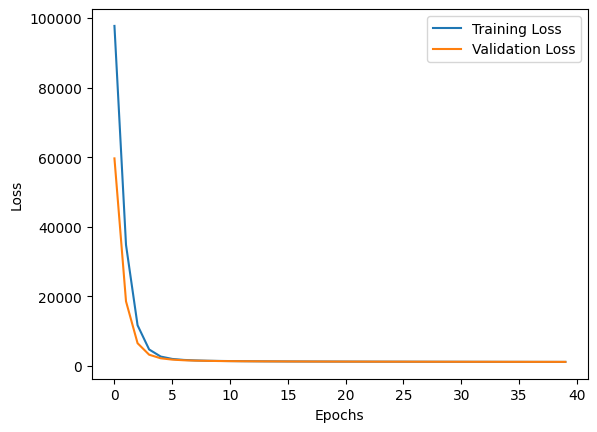

Saved model as model_1699989731.pth


In [22]:
# Get or train the model
weights = None # Force train
model = get_model(weights, train_loader, val_loader)

In [23]:
# Evaluate the model
evaluate_map(model, test_loader)

IndexError: too many indices for tensor of dimension 4

In [ ]:
# Draw some predictions
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.eval()
images, targets = next(iter(test_loader))
images = images.to(device)
predictions = model.detect(images, conf_thresh=0.5, iou_thresh=0.4)
detections = convert_predictions_to_boxes(predictions, conf_thresh=0.5)

for i in range(len(images)):
    img = to_pil_image(images[i])
    fig, ax = plt.subplots(1)
    ax.imshow(img)

    if detections[i] is not None:
        pred_boxes = detections[i][:, :4]
        scores = detections[i][:, 4]
        pred_labels = detections[i][:, 5:]

        for box, score, label in zip(pred_boxes, scores, pred_labels):
            # Get the class name:
            class_label = torch.argmax(label)
            class_name = list(VOC_LABELS.keys())[list(
                VOC_LABELS.values()).index(int(class_label.item()))]

            # Convert to xmin, ymin, xmax, ymax
            xmin = box[0] * IMAGE_SIZE
            ymin = box[1] * IMAGE_SIZE
            xmax = box[2] * IMAGE_SIZE
            ymax = box[3] * IMAGE_SIZE

            # Create a Rectangle patch
            rect = patches.Rectangle(
                (xmin, ymin),
                xmax - xmin,
                ymax - ymin,
                linewidth=1,
                edgecolor='r',
                facecolor='none'
            )

            # Add the patch to the Axes
            ax.add_patch(rect)

            plt.text(
                xmin,
                ymin,
                class_name,
                color='white',
                fontsize=8,
                bbox=dict(facecolor='red', edgecolor='none', pad=1)
            )

    plt.show()